In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download masoudnickparvar/brain-tumor-mri-dataset
!unzip brain-tumor-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.
87910968/87910968 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 batch_normalization_94 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1

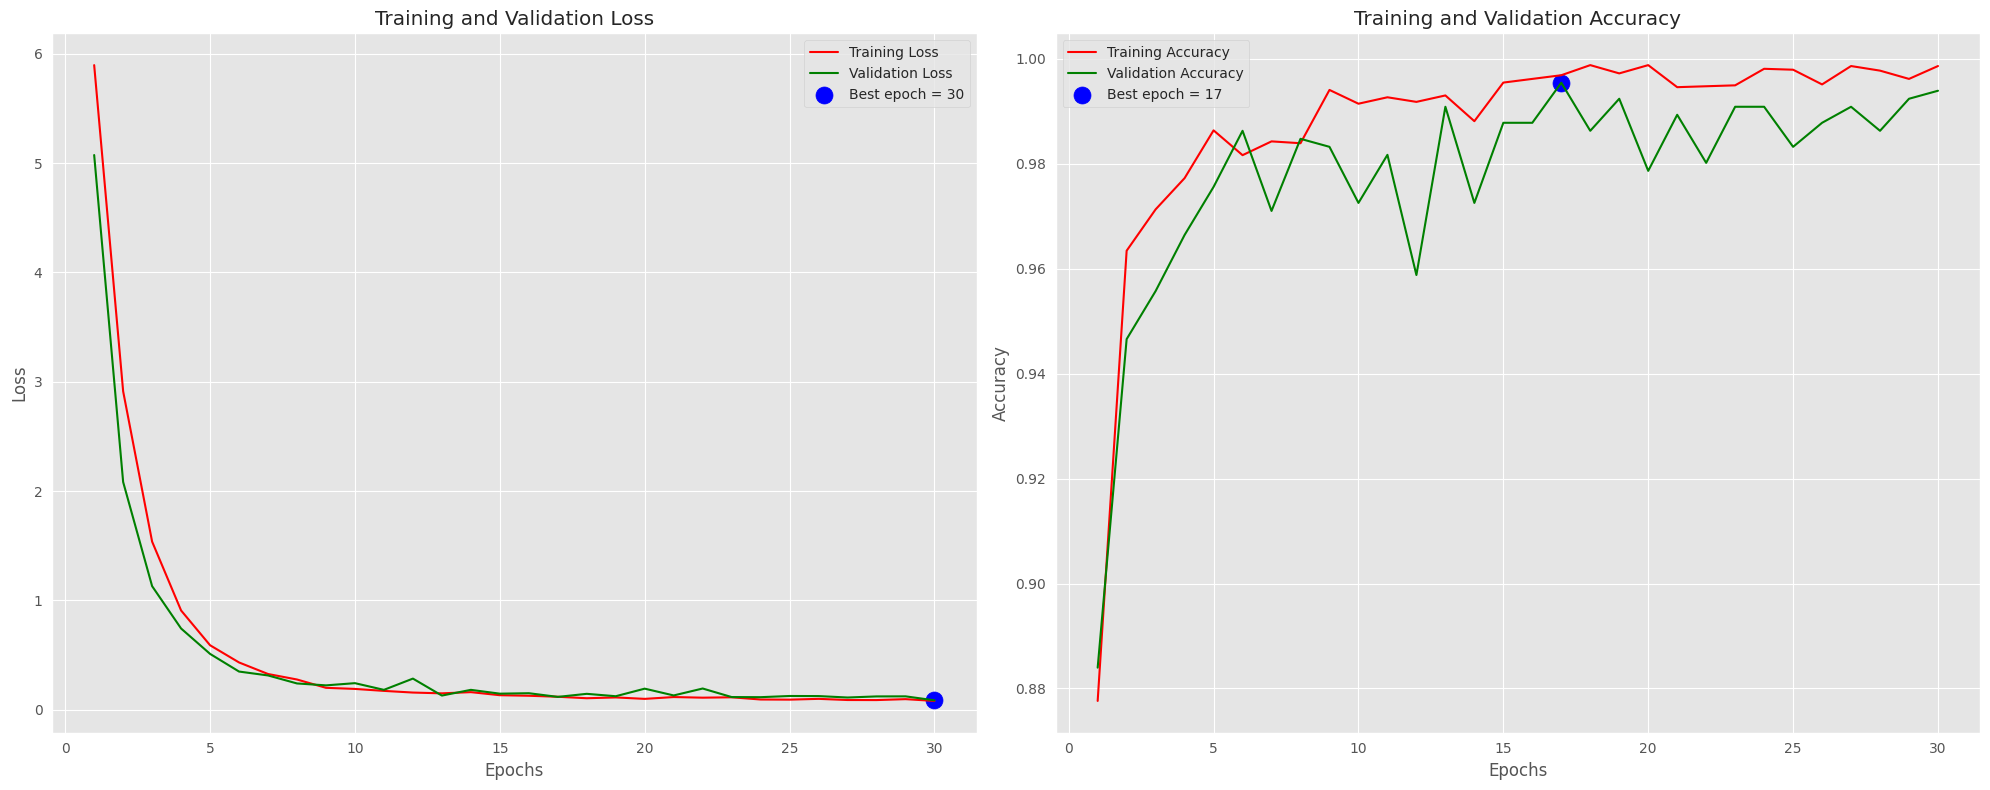

16/16 [==============================] - 1s 61ms/step - loss: 0.0694 - accuracy: 0.9961
Train Loss:  0.06226031482219696
Train Accuracy:  1.0
--------------------
Validation Loss:  0.08956806361675262
Validation Accuracy:  0.9921875
--------------------
Test Loss:  0.06939048320055008
Test Accuracy:  0.99609375
41/41 [==============================] - 3s 40ms/step


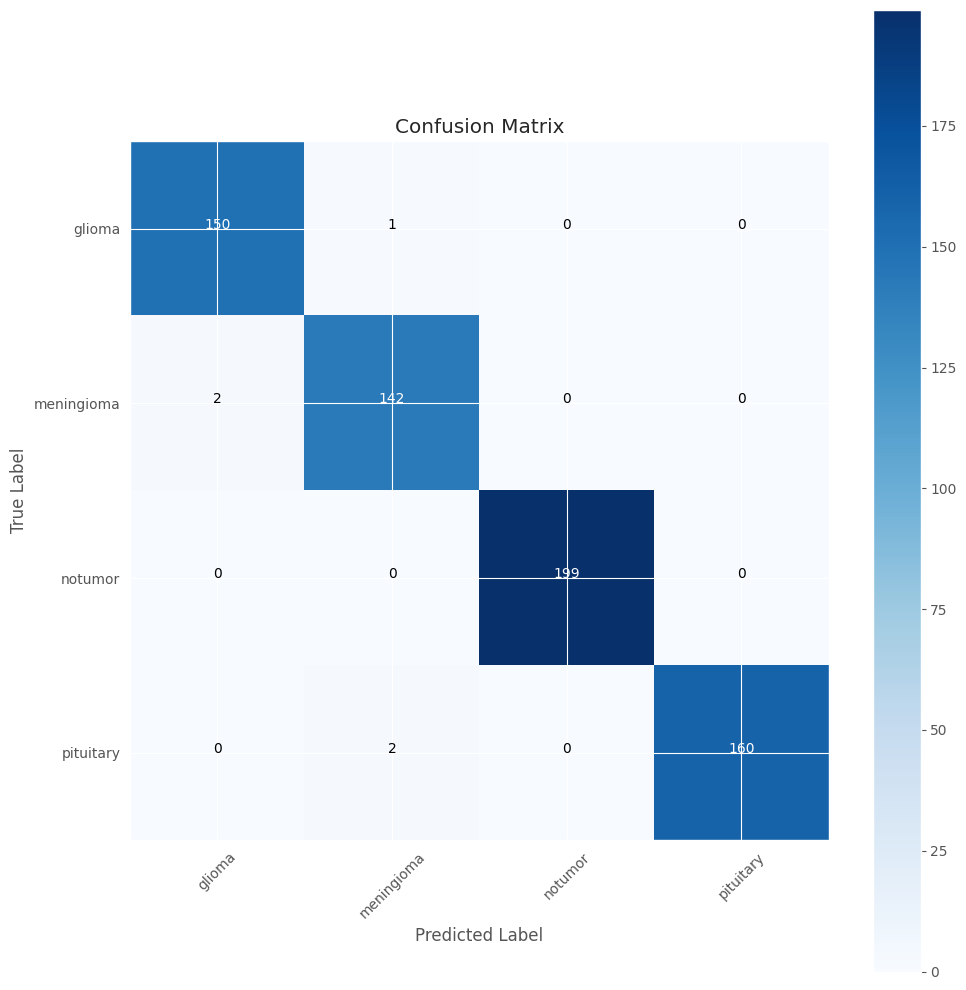

              precision    recall  f1-score   support

      glioma       0.99      0.99      0.99       151
  meningioma       0.98      0.99      0.98       144
     notumor       1.00      1.00      1.00       199
   pituitary       1.00      0.99      0.99       162

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



In [ ]:
import os
import shutil
import itertools
import pathlib
from PIL import Image

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings('ignore')

train_data_path = '/content/Training'
filepaths = []
labels = []
folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path, fold)
    filelists = os.listdir(f_path)
    for file in filelists:
        filepaths.append(os.path.join(f_path, file))
        labels.append(fold)

Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='label')
train_df = pd.concat([Fseries, Lseries], axis=1)

test_data_path = '/content/Testing'
filepaths = []
labels = []
folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path, fold)
    filelists = os.listdir(f_path)
    for file in filelists:
        filepaths.append(os.path.join(f_path, file))
        labels.append(fold)

Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='label')
test_df = pd.concat([Fseries, Lseries], axis=1)

valid, test = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=42)

img_size = (224, 224)
batch_size = 16

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='label', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen = ts_gen.flow_from_dataframe(valid, x_col='filepaths', y_col='label', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test, x_col='filepaths', y_col='label', target_size=img_size,
                                      class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

img_shape = (img_size[0], img_size[1], 3)
classes = train_gen.class_indices
num_class = len(classes)

base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.4, seed=75),
    Dense(num_class, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

class TestAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test_loss, test_acc = model.evaluate(test_gen, verbose=0)
        print(f'\nTesting loss: {test_loss}, Testing accuracy: {test_acc}\n')

Epochs = 30
history = model.fit(x=train_gen, epochs=Epochs, verbose=1, validation_data=valid_gen,
                    validation_steps=None, shuffle=False, callbacks=[TestAccuracyCallback()])

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i + 1 for i in range(len(train_acc))]

loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'

# Training history
plt.figure(figsize=(20, 8))
plt.style.use('ggplot')

plt.subplot(1, 2, 1)
plt.plot(Epochs, train_loss, 'r', label='Training Loss')
plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, val_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

train_score = model.evaluate(train_gen, steps=16, verbose=1)
valid_score = model.evaluate(valid_gen, steps=16, verbose=1)
test_score = model.evaluate(test_gen, steps=16, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(classification_report(test_gen.classes, y_pred, target_names=classes))

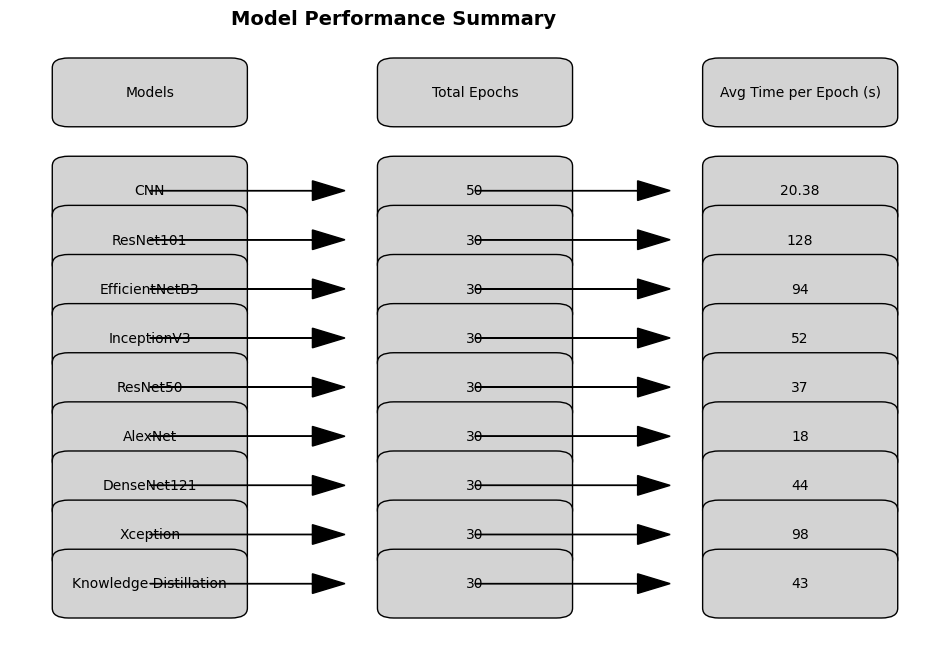

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

# Data
models = ['CNN', 'ResNet101', 'EfficientNetB3', 'InceptionV3', 'ResNet50', 'AlexNet', 'DenseNet121', 'Xception', 'Knowledge Distillation']
epochs = [50, 30, 30, 30, 30, 30, 30, 30, 30]
times = [20.38, 128, 94, 52, 37, 18, 44, 98, 43]

# Create figure
fig, ax = plt.subplots(figsize=(12, 8))
plt.axis('off')

# Draw rectangles and lines
def draw_box(ax, x, y, text, box_style):
    box = mpatches.FancyBboxPatch((x, y), width=1, height=0.5, boxstyle=box_style, ec="black", fc="lightgray")
    ax.add_patch(box)
    plt.text(x + 0.5, y + 0.25, text, ha='center', va='center', fontsize=10)

# Draw the boxes and arrows for the diagram
draw_box(ax, 1, 6, "Models", "round,pad=0.1")
for i, model in enumerate(models):
    draw_box(ax, 1, 5 - 0.5 * i, model, "round,pad=0.1")
    ax.arrow(1.5, 5.25 - 0.5 * i, 1, 0, head_width=0.2, head_length=0.2, fc='black', ec='black')

draw_box(ax, 3, 6, "Total Epochs", "round,pad=0.1")
for i, epoch in enumerate(epochs):
    draw_box(ax, 3, 5 - 0.5 * i, str(epoch), "round,pad=0.1")
    ax.arrow(3.5, 5.25 - 0.5 * i, 1, 0, head_width=0.2, head_length=0.2, fc='black', ec='black')

draw_box(ax, 5, 6, "Avg Time per Epoch (s)", "round,pad=0.1")
for i, time in enumerate(times):
    draw_box(ax, 5, 5 - 0.5 * i, str(time), "round,pad=0.1")

# Add title
plt.text(3, 7, "Model Performance Summary", ha='center', va='center', fontsize=14, weight='bold')

plt.show()

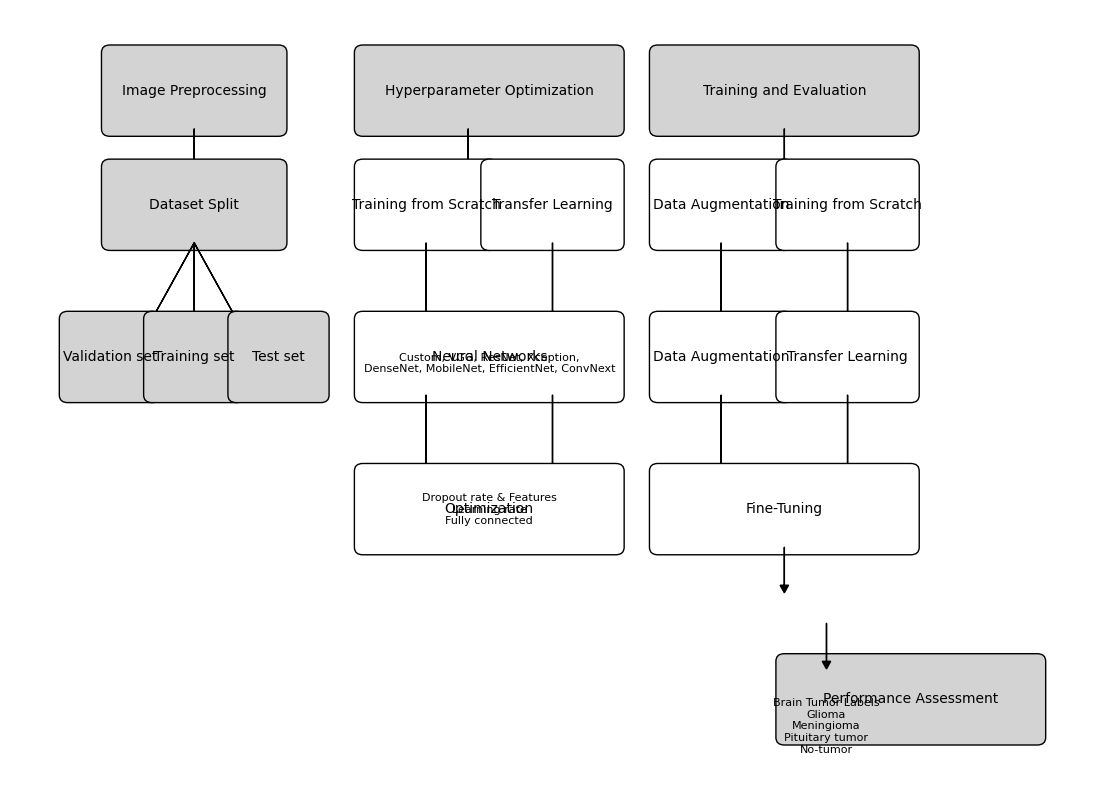

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def draw_box(ax, text, x, y, width, height, color='lightgrey'):
    box = mpatches.FancyBboxPatch((x, y), width, height, boxstyle="round,pad=0.1", ec="black", fc=color)
    ax.add_patch(box)
    plt.text(x + width / 2, y + height / 2, text, ha='center', va='center', fontsize=10)

fig, ax = plt.subplots(figsize=(14, 10))
plt.axis('off')

# Image Preprocessing
draw_box(ax, "Image Preprocessing", 0.5, 8, 2, 1)
ax.arrow(1.5, 8, 0, -0.5, head_width=0.1, head_length=0.1, fc='black', ec='black')

# Dataset Split
draw_box(ax, "Dataset Split", 0.5, 6.5, 2, 1)
ax.arrow(1.5, 6.5, -0.5, -1, head_width=0.1, head_length=0.1, fc='black', ec='black')
ax.arrow(1.5, 6.5, 0.5, -1, head_width=0.1, head_length=0.1, fc='black', ec='black')
ax.arrow(1.5, 6.5, 0, -1, head_width=0.1, head_length=0.1, fc='black', ec='black')

# Validation set
draw_box(ax, "Validation set", 0, 4.5, 1, 1)
# Training set
draw_box(ax, "Training set", 1, 4.5, 1, 1)
# Test set
draw_box(ax, "Test set", 2, 4.5, 1, 1)

# Hyperparameter Optimization
draw_box(ax, "Hyperparameter Optimization", 3.5, 8, 3, 1)
ax.arrow(4.75, 8, 0, -0.5, head_width=0.1, head_length=0.1, fc='black', ec='black')
draw_box(ax, "Training from Scratch", 3.5, 6.5, 1.5, 1, 'white')
draw_box(ax, "Transfer Learning", 5, 6.5, 1.5, 1, 'white')
ax.arrow(4.25, 6.5, 0, -1, head_width=0.1, head_length=0.1, fc='black', ec='black')
ax.arrow(5.75, 6.5, 0, -1, head_width=0.1, head_length=0.1, fc='black', ec='black')

draw_box(ax, "Neural Networks", 3.5, 4.5, 3, 1, 'white')
plt.text(5, 4.8, "Custom, VGG, ResNet, Xception,\nDenseNet, MobileNet, EfficientNet, ConvNext", ha='center', fontsize=8)
ax.arrow(4.25, 4.5, 0, -1, head_width=0.1, head_length=0.1, fc='black', ec='black')
ax.arrow(5.75, 4.5, 0, -1, head_width=0.1, head_length=0.1, fc='black', ec='black')

draw_box(ax, "Optimization", 3.5, 2.5, 3, 1, 'white')
plt.text(5, 2.8, "Dropout rate & Features\nLearning rate\nFully connected", ha='center', fontsize=8)

# Training and Evaluation
draw_box(ax, "Training and Evaluation", 7, 8, 3, 1)
ax.arrow(8.5, 8, 0, -0.5, head_width=0.1, head_length=0.1, fc='black', ec='black')
draw_box(ax, "Data Augmentation", 7, 6.5, 1.5, 1, 'white')
draw_box(ax, "Training from Scratch", 8.5, 6.5, 1.5, 1, 'white')
ax.arrow(7.75, 6.5, 0, -1, head_width=0.1, head_length=0.1, fc='black', ec='black')
ax.arrow(9.25, 6.5, 0, -1, head_width=0.1, head_length=0.1, fc='black', ec='black')

draw_box(ax, "Data Augmentation", 7, 4.5, 1.5, 1, 'white')
draw_box(ax, "Transfer Learning", 8.5, 4.5, 1.5, 1, 'white')
ax.arrow(7.75, 4.5, 0, -1, head_width=0.1, head_length=0.1, fc='black', ec='black')
ax.arrow(9.25, 4.5, 0, -1, head_width=0.1, head_length=0.1, fc='black', ec='black')

draw_box(ax, "Fine-Tuning", 7, 2.5, 3, 1, 'white')
ax.arrow(8.5, 2.5, 0, -0.5, head_width=0.1, head_length=0.1, fc='black', ec='black')

# Performance Assessment
draw_box(ax, "Performance Assessment", 8.5, 0, 3, 1)
ax.arrow(9, 1.5, 0, -0.5, head_width=0.1, head_length=0.1, fc='black', ec='black')

plt.text(9, -0.2, "Brain Tumor Labels\nGlioma\nMeningioma\nPituitary tumor\nNo-tumor", ha='center', fontsize=8)

plt.show()

In [6]:
import plotly.graph_objects as go

# Define the key components with larger boxes
components = {
    "Image Preprocessing": (0.5, 8),
    "Dataset Split": (0.5, 6.5),
    "Validation set": (0, 4.5),
    "Training set": (1, 4.5),
    "Test set": (2, 4.5),
    "Hyperparameter Optimization": (3.5, 8),
    "Training from Scratch": (3.5, 6.5),
    "Transfer Learning": (5, 6.5),
    "Neural Networks": (4.25, 5),
    "Optimization": (4.25, 2.5),
    "Training and Evaluation": (7, 8),
    "Data Augmentation": (7, 6.5),
    "Fine-Tuning": (7, 4.5),
    "Performance Assessment": (7, 2.5),
    "Results": (7, 0),
}

# Create the figure
fig = go.Figure()

# Add the boxes for each component with larger size
for name, (x, y) in components.items():
    fig.add_trace(go.Scatter(
        x=[x], y=[y],
        text=[name],
        mode="text",
        textfont=dict(size=12),
        hoverinfo="none"
    ))
    fig.add_shape(
        type="rect",
        x0=x-1, y0=y-0.75, x1=x+1, y1=y+0.75,
        line=dict(color="black"),
        fillcolor="lightgrey"
    )

# Add the arrows to connect the boxes
arrows = [
    ((0.5, 7.25), (0.5, 8)),
    ((0.5, 5.75), (0.5, 6.5)),
    ((0.25, 4.5), (0, 4.5)),
    ((0.75, 4.5), (1, 4.5)),
    ((1.25, 4.5), (2, 4.5)),
    ((4.25, 7.25), (4.25, 8)),
    ((5.25, 7.25), (5.25, 8)),
    ((4.25, 5.75), (4.25, 6.5)),
    ((5.25, 5.75), (5.25, 6.5)),
    ((4.25, 3.75), (4.25, 5)),
    ((5.25, 3.75), (5.25, 5)),
    ((7, 7.25), (7, 8)),
    ((7, 5.75), (7, 6.5)),
    ((7, 3.75), (7, 4.5)),
    ((7, 1.75), (7, 2.5)),
    ((7, 0.75), (7, 1)),
]

for (x0, y0), (x1, y1) in arrows:
    fig.add_annotation(
        x=x1, y=y1,
        ax=x0, ay=y0,
        xref="x", yref="y", axref="x", ayref="y",
        showarrow=True,
        arrowhead=2
    )

# Add model names under Training and Evaluation
model_names = [
    "CNN", "ResNet101", "EfficientNetB3", "InceptionV3", "ResNet50", "AlexNet", 
    "DenseNet121", "Xception", "Knowledge Distillation"
]
for i, model in enumerate(model_names):
    fig.add_trace(go.Scatter(
        x=[8.5], y=[6 - i*0.5],
        text=[model],
        mode="text",
        textfont=dict(size=10),
        hoverinfo="none"
    ))

# Update layout
fig.update_layout(
    width=1200,
    height=800,
    showlegend=False,
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    margin=dict(l=50, r=50, t=50, b=50)
)

fig.show()